In [1]:
# -*- coding: utf-8 -*-

In [1]:
import pandas as pd
import numpy as np

In [2]:
# time 컬럼은 문자로 읽기 위해  dtype={'time':object} 사용
df = pd.read_csv( '2020-10-30_futures.csv', dtype={'time':object} )

In [3]:
# Vol Bar를 만들기 위해 새 df 만듬
df1 = df.loc[:, ['time','price','type','qty']]

In [4]:
# time 컬럼을 hhmmss에서 hhmm으로 변경
df1['time'] = df1['time'].map( lambda x : x[-6:-2] )

In [5]:
# qty(체결수량)이 0인 데이터 삭제
df1.drop( df1.index[df1['qty'] == 0], inplace = True )

In [6]:
df1['BUY'] = (df1['type']=='+') * df1['qty']
df1['SELL'] = (df1['type']=='-') * df1['qty']
df1.tail(5)

,time,price,type,qty,BUY,SELL
13829,1529,301.45,+,1,1,0
13830,1529,301.45,+,6,6,0
13831,1529,301.40,-,8,0,8
13832,1529,301.35,+,1,1,0
13833,1529,301.30,-,3,0,3


In [7]:
df1.tail(5)

,time,price,type,qty,BUY,SELL
13829,1529,301.45,+,1,1,0
13830,1529,301.45,+,6,6,0
13831,1529,301.40,-,8,0,8
13832,1529,301.35,+,1,1,0
13833,1529,301.30,-,3,0,3


In [31]:
df_volBar = pd.DataFrame(columns=['tm','op','hi','lo','cl','vol','b','s'])

sumOf=0
sumOfBid=0
sumOfAsk=0
t0 = df1.index[0]
ix=0
for i in df1.index:
    sumOf += df1['qty'].loc[i]
    sumOfBid += df1['BUY'].loc[i]
    sumOfAsk += df1['SELL'].loc[i]
    if sumOf>100:
        tme = df1['time'].loc[i]
        opn = df1['price'].loc[t0]
        hig = max(df1['price'].loc[t0:i])
        low = min(df1['price'].loc[t0:i])
        clz = df1['price'].loc[i]
        qty = df1['qty'].loc[i]
        bid = df1['BUY'].loc[i]
        ask = df1['SELL'].loc[i]
#         print(df1['time'].loc[i], op, hi, lo, cl, bd, ak)
        df_volBar.loc[ix] = [tme, opn, hig, low, clz, sumOf, sumOfBid, sumOfAsk]
        t0 = i
        ix+=1
        sumOf = 0    
        sumOfBid = 0
        sumOfAsk = 0

In [32]:
df_volBar.tail(5)

,tm,op,hi,lo,cl,vol,b,s
413,1527,301.80,301.95,301.80,301.95,102,51,51
414,1527,301.95,301.95,301.80,301.85,133,83,27
415,1528,301.85,301.85,301.75,301.85,101,77,24
416,1528,301.85,301.85,301.70,301.70,101,32,69
417,1529,301.70,301.75,301.60,301.60,102,17,85


# True PIN

In [34]:
tpin=abs(df_volBar['b']-df_volBar['s'])/vol

In [36]:
df_volBar['TPIN']=tpin

<AxesSubplot:>

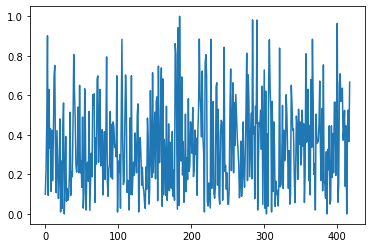

In [38]:
tpin.plot()

<AxesSubplot:>

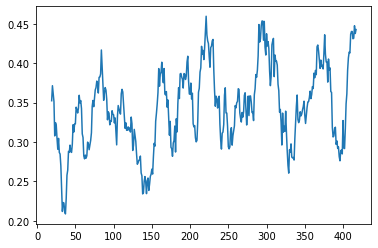

In [41]:
tpin.rolling(20).mean().plot()

# VPIN

In [42]:
from math import *
import math
import numpy as np
from scipy.stats import *

def std(list):
    element = 0 
    for item in list:
        element = element + float((item**2)/( len(list)))
    return math.sqrt(element)

def phi(x):
    #'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

def calx(v_i,delta_p_i,sigma):
    x = v_i * phi(delta_p_i/sigma)
    return x

In [43]:
df_volBar['chg']=df_volBar['cl']-df_volBar['op']

In [44]:
high = df_volBar["hi"].tolist()
low =  df_volBar["lo"].tolist()
vol =  df_volBar["vol"].tolist()
chg = df_volBar["chg"].tolist()
#date = df["date"].tolist()
time =  df_volBar["tm"].tolist()
sigma = df_volBar['chg'].rolling(20).std() #calculate standard deviation
totalvol = sum(vol)

In [45]:
z=df_volBar['chg'].apply(lambda x: norm.cdf(x/sigma))

In [46]:
chg = df_volBar["chg"]
chg_mean = df_volBar["chg"].mean()
z=norm.cdf((chg-chg_mean)/sigma)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [47]:
pd.DataFrame(z).describe()

,0
count,399.000000
mean,0.503164
std,0.288873
min,0.001961
25%,0.249925
50%,0.538387
75%,0.771974
max,0.997370


In [48]:
buy=vol*z
sell=vol*(1-z)
vpin=abs(buy-sell)/vol

<AxesSubplot:>

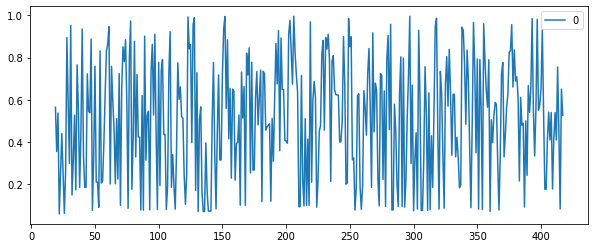

In [49]:
pd.DataFrame(vpin).plot(figsize=(10,4))

<AxesSubplot:>

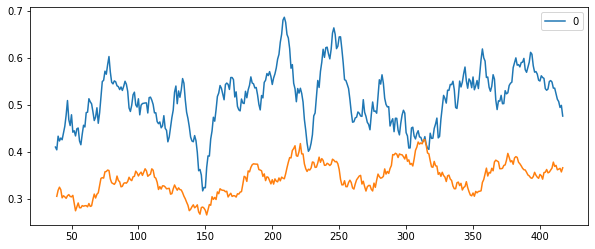

In [58]:
pd.DataFrame(vpin).rolling(20).mean().plot(figsize=(10,4))
tpin.rolling(40).mean().plot()


<AxesSubplot:>

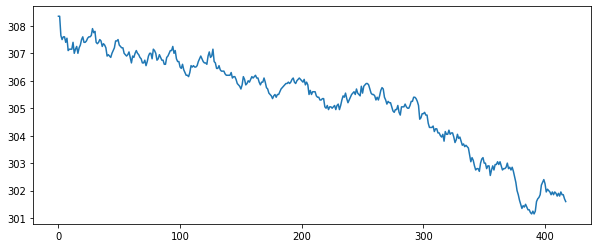

In [61]:
df_volBar['cl'].plot(figsize=(10,4))

# Time BAR

In [26]:
filter=list(set(df1['time']))

df_tmBar=pd.DataFrame(columns=['tm','op','hi','lo','cl','vol','b','s'])
i=0
for f in filter:
    filtd=df1[df1['time'].str.contains(f)]
    op=sum(filtd['price'][:1])
    hi=max(filtd['price'])
    lo=min(filtd['price'])
    cl=sum(filtd['price'][-1:])
    vl=sum(filtd['qty'])
    b=sum(filtd['BUY'])
    s=sum(filtd['SELL'])
    df_tmBar.loc[i]=[f,op,hi,lo,cl,vl,b,s]
    i=i+1

In [27]:
df_tmBar.tail(5)

,tm,op,hi,lo,cl,vol,b,s
373,1257,304.95,305.05,304.95,304.95,51,22,22
374,1249,305.10,305.15,305.00,305.00,100,66,34
375,0936,307.00,307.40,307.00,307.35,78,60,18
376,1138,306.15,306.25,306.05,306.05,128,36,92
377,0918,307.65,307.70,307.55,307.70,127,69,58


# EMA

In [63]:
def EMA(data, n):
    ma = []
    
    # data 첫 부분에 na 가 있으면 skip한다
    x = 0
    while True:
        if math.isnan(data[x]):
            ma.append(data[x])
        else:
            break;
        x += 1
        
    # x ~ n - 1 기간까지는 na를 assign 한다
    for i in range(x, x + n - 1):
        ma.append(np.nan)
    
    # x + n - 1 기간은 x ~ x + n - 1 까지의 평균을 적용한다
    sma = np.mean(data[x:(x + n)])
    ma.append(sma)
    
    # x + n 기간 부터는 EMA를 적용한다
    k = 2 / (n + 1)
    
    for i in range(x + n, len(data)):
        #print(i, data[i])
        ma.append(ma[-1] + k * (data[i] - ma[-1]))
    
    return pd.Series(ma, index=data.index)

In [69]:
df_tmBar['EMA']= EMA(df_tmBar['cl'], 5)

In [71]:
df_tmBar.tail()

,tm,op,hi,lo,cl,vol,b,s,EMA
373,1257,304.95,305.05,304.95,304.95,51,22,22,305.690490
374,1249,305.10,305.15,305.00,305.00,100,66,34,305.460327
375,0936,307.00,307.40,307.00,307.35,78,60,18,306.090218
376,1138,306.15,306.25,306.05,306.05,128,36,92,306.076812
377,0918,307.65,307.70,307.55,307.70,127,69,58,306.617875


In [72]:
EMA(df_tmBar['cl'], 5)

0             NaN
1             NaN
2             NaN
3             NaN
4      306.120000
          ...    
373    305.690490
374    305.460327
375    306.090218
376    306.076812
377    306.617875
Length: 378, dtype: float64

# MACD

In [74]:
def MACD(ohlc, nFast=12, nSlow=26, nSig=9, percent=True):
    ema1 = EMA(ohlc, nFast)
    ema2 = EMA(ohlc, nSlow)
    
    if percent:
        macdLine =  100 * (ema1 - ema2) / ema2
    else:
        macdLine =  ema1 - ema2
    signalLine = EMA(macdLine, nSig)
    
    return pd.DataFrame(macdLine - signalLine, index=ohlc.index)


In [75]:
MACD(df_tmBar['cl']).head()

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


# RSE

In [20]:
def RSI(ohlc, n=14):
    closePrice = pd.DataFrame(ohlc)
    U = np.where(closePrice.diff(1) > 0, closePrice.diff(1), 0)
    D = np.where(closePrice.diff(1) < 0, closePrice.diff(1) * (-1), 0)
    
    U = pd.DataFrame(U, index=ohlc.index)
    D = pd.DataFrame(D, index=ohlc.index)
    
    AU = U.rolling(window=n).mean()
    AD = D.rolling(window=n).mean()

    return 100 * AU / (AU + AD)


In [21]:
RSI(df_tmBar['cl'])

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
373,51.690821
374,50.952381
375,49.878345
376,47.101449


# OBV

In [77]:
from scipy.stats import norm

def OBV(ohlcv, ext=True):
    obv = [0]
    
    # 기존의 OBV
    if ext == False:
        # 기술적 지표인 OBV를 계산한다
        for curr, prev in zip(ohlcv.itertuples(), ohlcv.shift(1).itertuples()):
            if math.isnan(prev.vol):
                continue
            
            if curr.cl > prev.cl:
                obv.append(obv[-1] + curr['qty'])
            if curr.cl < prev.cl:
                obv.append(obv[-1] - curr['qty'])
            if curr.cl == prev.cl:
                obv.append(obv[-1])
    # Extendedd OBV
    else:
        # 가격 변화를 측정한다. 가격 변화 = 금일 종가 - 전일 종가
        deltaClose = ohlcv['cl'].diff(1)
        
        deltaClose = deltaClose.dropna(axis = 0)
        
        # 가격 변화의 표준편차를 측정한다
        stdev = np.std(deltaClose)
        
        for curr, prev in zip(ohlcv.itertuples(), ohlcv.shift(1).itertuples()):
            if math.isnan(prev.cl):
                continue
            
            buy = curr.vol * norm.cdf((curr.cl - prev.cl) / stdev)
            sell = curr.vol - buy
            bs = abs(buy - sell)
            
            if curr.cl > prev.cl:
                obv.append(obv[-1] + bs)
            if  curr.cl < prev.cl:
                obv.append(obv[-1] - bs)
            if curr.cl == prev.cl:
                obv.append(obv[-1])
        
    return pd.DataFrame(obv, index=ohlcv.index)


In [78]:
df_tmBar = df_tmBar.dropna(subset=['vol'])

In [79]:
df_tmBar.head()

,tm,op,hi,lo,cl,vol,b,s,EMA
0,1357,305.15,305.15,305.00,305.05,88,42,46,NaN
1,0922,307.70,307.90,307.70,307.70,100,34,46,NaN
2,1413,304.70,304.85,304.65,304.85,173,143,30,NaN
3,1030,306.15,306.30,306.10,306.25,151,65,86,NaN
4,0948,306.85,306.90,306.75,306.75,89,41,48,306.12


In [80]:
OBV(df_tmBar, ext=True).tail()

,0
373,-1852.196601
374,-1850.360827
375,-1794.160832
376,-1851.803616
377,-1781.655720


# Smooth

In [28]:
from scipy.stats import norm
from scipy import ndimage

# 시계열을 평활화한다
def smooth(data, s=5):
    y = data.values
    w = np.isnan(y)
    y[w] = 0.
    sm = ndimage.gaussian_filter1d(y, s)
    return pd.DataFrame(sm)

In [29]:
smooth(df_tmBar['cl'], s=5)

,0
0,305.736527
1,305.725710
2,305.702440
3,305.663845
4,305.606724
...,...
373,305.450477
374,305.508307
375,305.557506
376,305.593205


# EMA 크로스 전략

In [81]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 1번 방법
# DataReader API를 통해서 yahoo finance의 주식 종목 데이터를 가져온다.
start = datetime(2018,1,1)
end = datetime(2019,12,31)
df = pdr.DataReader('005930.KS', 'yahoo', start, end)

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [82]:
df['sma5']=df['Close'].rolling(5).mean()
df['sma20']=df['Close'].rolling(20).mean()
df['sma100']=df['Close'].rolling(100).mean()
df['sma200']=df['Close'].rolling(200).mean()

<AxesSubplot:xlabel='Date'>

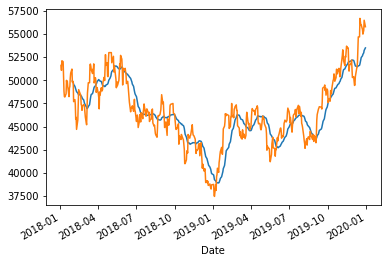

In [83]:
df['sma20'].plot()
df['Close'].plot()

In [84]:
df['ema5']=df['Close'].ewm(5).mean()
df['ema20']=df['Close'].ewm(20).mean()
df['ema100']=df['Close'].ewm(100).mean()
df['ema200']=df['Close'].ewm(200).mean()

<AxesSubplot:xlabel='Date'>

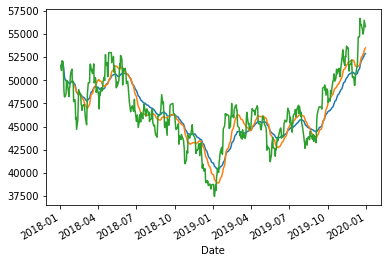

In [85]:
df['ema20'].plot()
df['sma20'].plot()
df['Close'].plot()

In [86]:
def weighted_mean(weight_array):
    def inner(x):
        return (weight_array * x).mean()
    return inner

weights = np.arange(1,6)
wma5 = df['Close'].rolling(5).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

weights = np.arange(1,21)
wma20 = df['Close'].rolling(20).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

weights = np.arange(1,101)
wma100 = df['Close'].rolling(100).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

weights = np.arange(1,201)
wma200 = df['Close'].rolling(200).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

df['wma5'] = wma5
df['wma20'] = wma20
df['wma100'] = wma100
df['wma200'] = wma200

<AxesSubplot:xlabel='Date'>

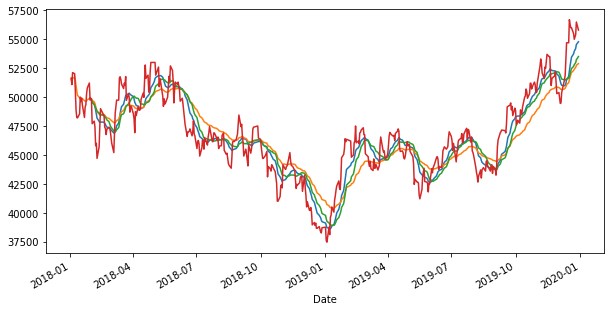

In [87]:
df['wma20'].plot(figsize=(10,5))
df['ema20'].plot()
df['sma20'].plot()
df['Close'].plot()

# EWMA Volatiltiy

In [88]:
def CalculateEWMAVol (ReturnSeries, Lambda):   
    SampleSize = len(ReturnSeries)
    Average = ReturnSeries.mean()

    e = np.arange(SampleSize-1,-1,-1)
    r = np.repeat(Lambda,SampleSize)
    vecLambda = np.power(r,e)

    sxxewm = (np.power(ReturnSeries-Average,2)*vecLambda).sum()
    Vart = sxxewm/vecLambda.sum()
    EWMAVol = math.sqrt(Vart)

    return (EWMAVol)

def CalculateVol (R, Lambda):
    Vol = pd.Series(index=R.columns)
    for facId in R.columns:
        Vol[facId] = CalculateEWMAVol(R[facId], Lambda)

    return (Vol)

In [89]:
df_tmp=df['Close'].pct_change()
df_chg=pd.DataFrame(df_tmp)

In [100]:
import math
CalculateVol(df_chg, 0.94)

Close    0.014579
dtype: float64

In [101]:
df_chg.head()

,Close
Date,
2018-01-03,NaN
2018-01-04,-0.010461
2018-01-05,0.020360
2018-01-08,-0.001919
2018-01-09,-0.031142


In [104]:
df_chg

,Close
Date,
2018-01-03,NaN
2018-01-04,-0.010461
2018-01-05,0.020360
2018-01-08,-0.001919
2018-01-09,-0.031142
...,...
2019-12-23,-0.008929
2019-12-24,-0.009009
2019-12-26,0.007273


In [112]:
df_tmp=df_chg.copy()

In [113]:
decay_factor = 0.94
decay_f = np.arange(df_tmp.shape[0], 0, -1)
decay_f = decay_factor ** decay_f
decay_sum = sum(decay_f)
w = decay_f / decay_sum
avg_weight = np.ones(df_tmp.shape[0]) / df_tmp.shape[0]
T, N = df_tmp.shape[0], df_tmp.shape[1]
temp = df_tmp - df_tmp * np.tile(avg_weight, (T, 1)).T
temp = np.dot(temp.T, temp * np.tile(w, (T, 1)).T)
temp = 0.5 * (temp + temp.T)
R = np.diag(temp)
sigma = np.sqrt(R)
R = temp / np.sqrt(np.dot(R, R.T))

ValueError: Unable to coerce to DataFrame, shape must be (487, 1): given (487, 487)

sigma is volatility, R is corr matrix and temp is covariance matrix.

In [106]:
sigma

array([], dtype=float64)

In [107]:
R

array([], shape=(0, 0), dtype=float64)

# VWAP

In [105]:
df['vwap']=(df['bid1']+df['ask1']+df['bid2']+df['ask2']+df['bid3']+df['ask3'])/6.0

In [106]:
df['price'].plot(figsize=(10,5))

In [ ]:
df['mid'].iloc[95:].plot()
df['bid1'].loc[95:].plot(figsize=(10,5))
df['ask1'].loc[95:].plot(figsize=(10,5))

In [108]:
df.head(4)

,name,symbol,time,price,type,qty,bid1,bid2,bid3,bid4,...,bid4qty,bid5qty,ask1qty,ask2qty,ask3qty,ask4qty,ask5qty,total_bid_qty,totla_ask_qty,vwap
0,F 2012,101QC000,085951,309.2,,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,5651,6954,0.0
1,F 2012,101QC000,085952,309.2,,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,5654,6972,0.0
2,F 2012,101QC000,085953,309.2,,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,5657,6987,0.0
3,F 2012,101QC000,085954,309.2,,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,5658,6996,0.0


# 옵션

In [4]:
df=pd.read_csv('2020-10-30_calloptions.csv', engine='python')

In [5]:
df.head()

,종목명,종목코드,시간,현재가,체결구분,체결수량,미결제약정,이론가,행사가격,델타,감마,베가,세타,로,내재변동성,역사적변동성,CD금리
0,C 2011 322.5,201QB322,153156,1.36,+,2,13589,1.26,322.5,0.2015,0.0232,0.1911,-0.1022,0.0286,18.18,17.55,0.63
1,C 2011 342.5,201QB342,153004,0.03,-,1,16119,0.02,342.5,0.0076,0.0017,0.0201,-0.0075,0.0011,17.77,17.55,0.63
2,C 2011 315.0,201QB315,153124,3.79,-,1,8948,3.37,315.0,0.4142,0.0302,0.2607,-0.1519,0.0584,19.27,17.55,0.63
3,C 2011 320.0,201QB320,153156,1.98,+,2,11976,1.77,320.0,0.2661,0.0266,0.2332,-0.1224,0.0377,18.50,17.55,0.63
4,C 2011 317.5,201QB317,153156,2.79,+,1,7719,2.47,317.5,0.3382,0.0290,0.2319,-0.1411,0.0478,18.88,17.55,0.63


In [7]:
df=pd.read_csv('2020-10-30_putoptions.csv', engine='python')

In [8]:
df.head()

,종목명,종목코드,시간,현재가,체결구분,체결수량,미결제약정,이론가,행사가격,델타,감마,베가,세타,로,내재변동성,역사적변동성,CD금리
0,P 2011 300.0,301QB300,153156,2.13,+,2,16085,0.91,300.0,-0.2208,0.0183,0.1823,-0.1439,-0.0331,24.28,17.55,0.63
1,P 2011 277.5,301QB277,153156,0.33,-,1,10263,0.00,277.5,-0.0384,0.0040,0.0572,-0.0515,-0.0057,31.34,17.55,0.63
2,P 2011 287.5,301QB287,153152,0.75,-,3,13839,0.06,287.5,-0.0837,0.0082,0.0921,-0.0857,-0.0125,28.16,17.55,0.63
3,P 2011 255.0,301QB255,151339,0.05,-,5,20473,0.00,255.0,-0.0059,0.0007,0.0169,-0.0127,-0.0009,37.74,17.55,0.63
4,P 2011 302.5,301QB302,153152,2.62,+,1,11150,1.39,302.5,-0.2642,0.0209,0.2248,-0.1507,-0.0396,23.53,17.55,0.63
